# Visualizing nodes and their features

## Load model

In [54]:
from utils import load_checkpoint
from model import GraphMatchingNetwork

# Name of the model
filename = "gmn_northern-microwave-27"

# Load the model
checkpoint = load_checkpoint(filename)

# Retrieve state dict and configurations
state_dict = checkpoint['state_dict']
cfg = checkpoint['config']

# Initialize model
model = GraphMatchingNetwork(cfg)

# Load weights (state dict) into the model
model.load_state_dict(state_dict)  # should output "<All keys matched successfully>"

<All keys matched successfully>

## Two random graphs

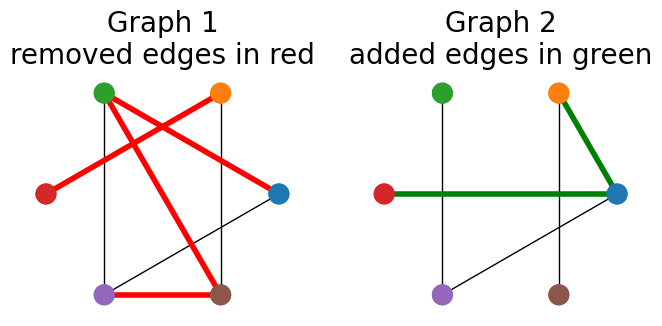

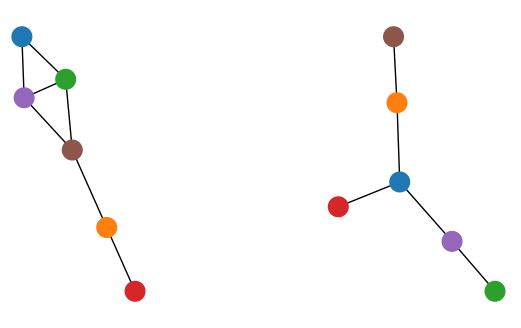

In [2]:
from utils import generate_binomial_graph, substitute_random_edges
from plot import plot_difference_graphs, plot_graph_beautiful, set_figure
import matplotlib.pyplot as plt
import random

# Sample 2 random binomial graphs
# We set the seed for reproducibility
N, pe, k = 6, 0.2, 1  # number of nodes; edge probability; number of substitutions
G1,_ = generate_binomial_graph(num_nodes=N, pe=pe, seed=1)
G2,_ = generate_binomial_graph(num_nodes=N, pe=pe, seed=1234)
# random.seed(1)
# G2 = substitute_random_edges(G1, k)

# Get colors for the nodes: base it on a known cmap
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(N)]

# Plot differences in graphs
plot_difference_graphs(G1, G2, node_color=colors)

# Plot differences in graphs
fs=4
_, axs = set_figure(1, 2, fs=fs, fc="white")
plot_graph_beautiful(G1, axs[0], c_node=colors, pos="spring", node_size=50*fs, edge_size=fs/4)
plot_graph_beautiful(G2, axs[1], c_node=colors, pos="spring", node_size=50*fs, edge_size=fs/4)

# plt.savefig(f"./dump/two_small_graph_N={N}_kp={k}_pe={0.2}_GED=high_spring.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Extract features

In [3]:
from graphs import gnn_inference

# Get node and graph features
graphs = [G1, G2]
node_feats, graph_feats = gnn_inference(graphs, model=model, cfg=cfg)

# Print some information
print(f"## Shape node features\n\t{node_feats[5].shape}\n\n"
      f"## Shape graph features\n\t{graph_feats.shape}\n")

## Shape node features
	torch.Size([12, 32])

## Shape graph features
	torch.Size([2, 128])



## Plot node features

$\bullet$ 1) Plot node features for 1 graph across GConv layers (nr subplots = nr layers)
$\bullet$ 2) Plot node feature average (+ std) for $N$ graphs across GConv layers (nr subplots = nr layers)
$\bullet$ 3) Plot node feature size average (+std) for $N$ graphs across GConv layers (1 plot)

In [3]:
from plot import set_aspect_ratio
import numpy as np

def plot_node_features(axs, node_feats, N1, N2,
                       ratio=0.25, fc="white",
                       xlabel=None, ylabel="Feature index",
                       ylim=[-1, 1],
                       **kwargs):

    # Determine text color based on background color
    tc = "white" if fc == "black" else "black"

    # Loop through layers
    for i, (k, feats_k) in enumerate(node_feats.items()):

        for j in [1, 2]:

            ax = axs[i*2 + j - 1]

            # Extract node features at layer k
            feats = feats_k[:N1] if j == 1 else feats_k[N1:]

            # Plot features
            labels = [f"Node {i}" for i in range(N1 if j==1 else N2)]
            ax.plot(np.array(feats.t()), label=labels, **kwargs)

            # Make up axis
            ax.spines['bottom'].set_color(tc)
            ax.spines['left'].set_color(tc)
            ax.tick_params(axis='x', colors=tc)
            ax.tick_params(axis='y', colors=tc)

            # Set axis labels
            ax.axis(True)
            ax.set_ylabel(xlabel, color=tc)
            ax.set_xlabel(ylabel, color=tc)

            # Set limits
            ax.set_ylim(ylim)

            # Set axis title
            ax.set_title(f"G{j} @ Layer {k}")

            # Set aspect
            set_aspect_ratio(ax, ratio=ratio)

            # Legend
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

            # Make room for legend
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

### 1) Node features @ k / Random and Pre-trained

Random initialized network

In [92]:
# Initialize model
model = GraphMatchingNetwork(cfg)

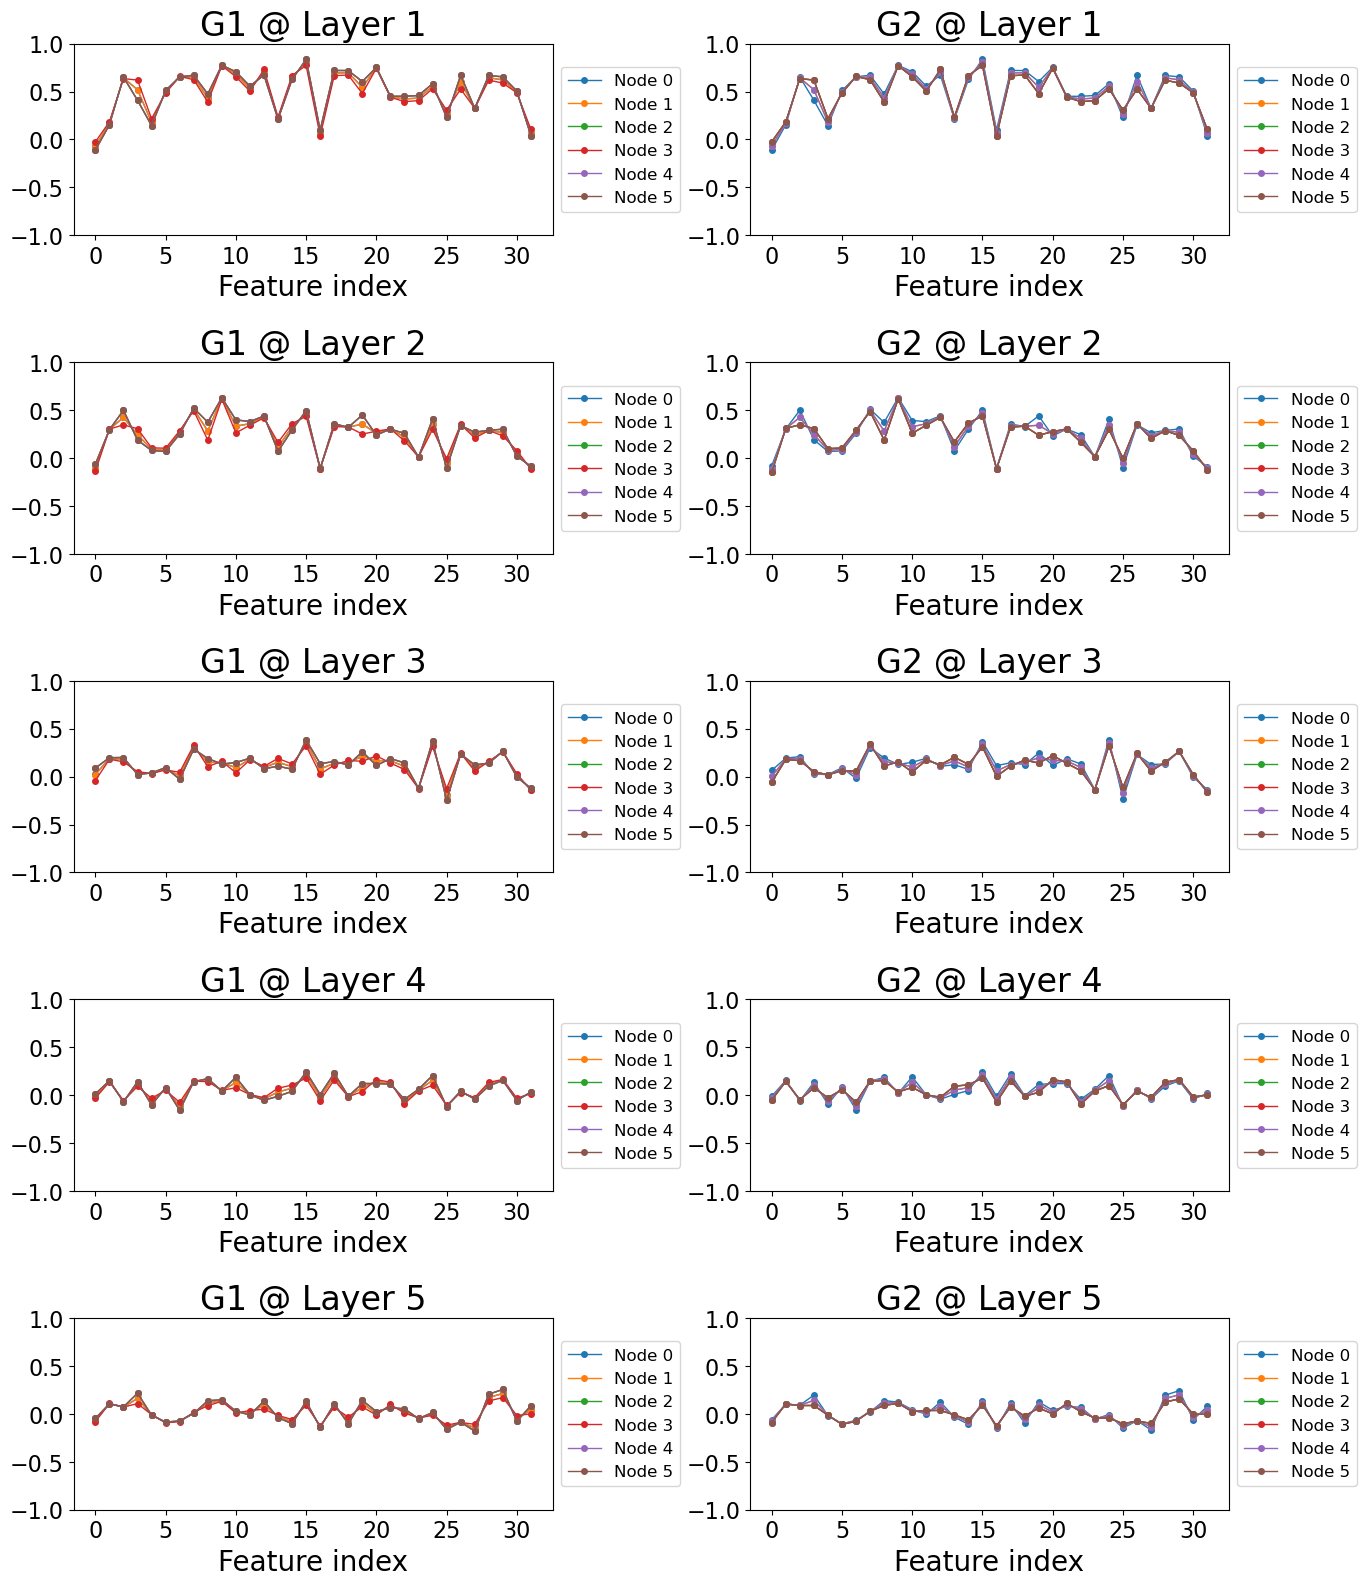

In [93]:
from plot import set_figure

# Get node and graph features
N1, N2 = G1.number_of_nodes(), G2.number_of_nodes()
graphs = [G1, G2]
node_feats, _ = gnn_inference(graphs, model=model, cfg=cfg)

# Set figure
fc="white"
ratio = 0.4
_, axs = set_figure(cfg.model.num_layers, 2,
                    fs=8, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fs_legend=1.5,
                    fc=fc, ratio=ratio+0.1)

# Plot features
plot_node_features(axs, node_feats, N1, N2,
                   fc=fc, ratio=ratio,
                   marker="o", markersize=4, linewidth=1,
                   ylim=[-1, 1])

# Save figure
plt.savefig(f"./dump/node_features_random_network_GED=high.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

Pre-trained model

In [86]:
# Initialize model
model = GraphMatchingNetwork(cfg)

# Load pre-trained weights
model.load_state_dict(state_dict)

<All keys matched successfully>

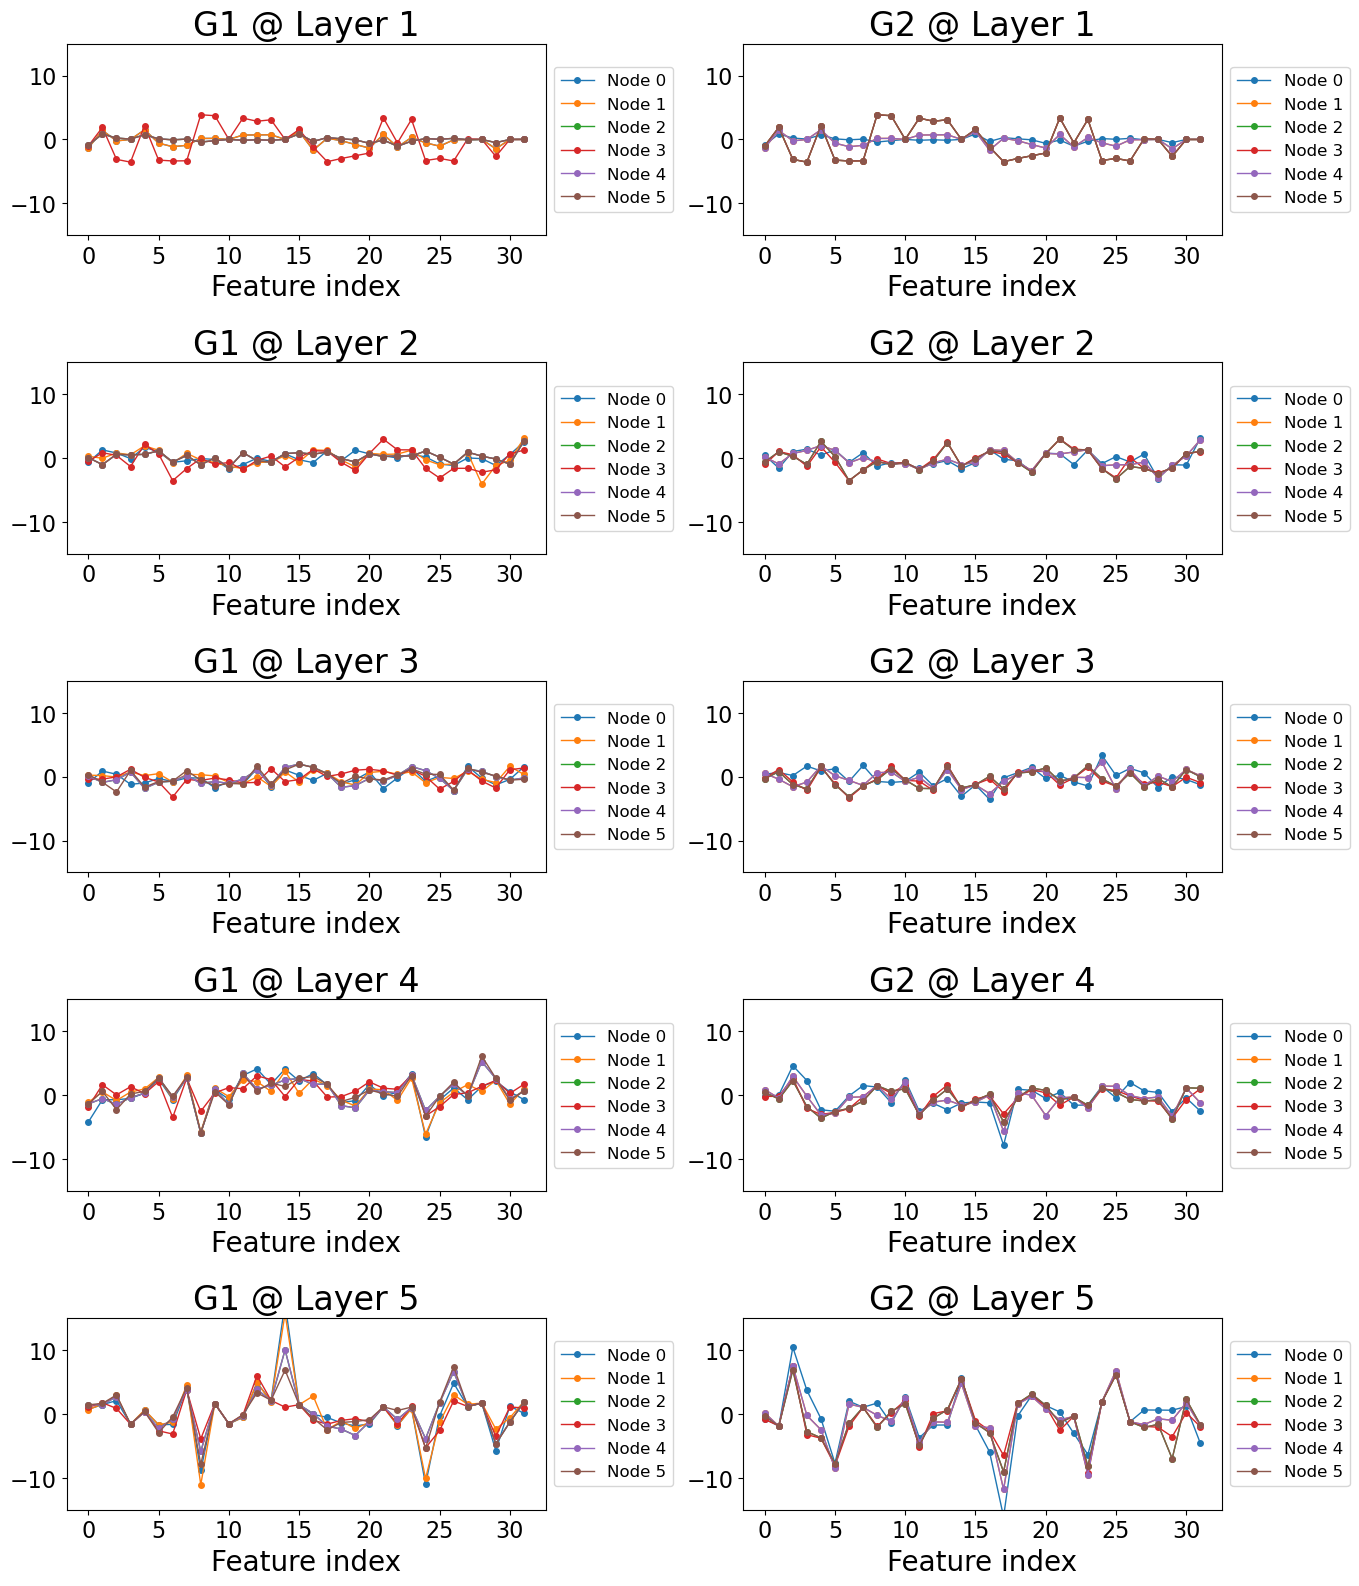

In [90]:
# Get node and graph features
node_feats, _ = gnn_inference(graphs, model=model, cfg=cfg)

# Set figure
fc="white"
ratio = 0.4
_, axs = set_figure(cfg.model.num_layers, 2,
                    fs=8, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fs_legend=1.5,
                    fc=fc, ratio=ratio+0.1)

# Plot features
plot_node_features(axs, node_feats, N1, N2,
                   fc=fc, ratio=ratio,
                   marker="o", markersize=4, linewidth=1,
                   ylim=[-15, 15])

# Save figure
plt.savefig(f"./dump/node_features_pretrained_network_GED=high.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

### 2) Node feature average @ k / Random and Pre-trained

In [25]:
import torch
from plot import set_figure

def compute_feature_distribution(X, dim=0):

    # Compute distribution across nodes
    sig, mu = torch.std_mean(X, dim=dim)

    return mu, sig

def plot_node_feature_avg(axs, node_feats,
                       ratio=0.25, fc="white",
                       xlabel=None, ylabel="Feature index",
                       ylim=[-1, 1],
                       **kwargs):

    # Determine text color based on background color
    tc = "white" if fc == "black" else "black"

    # Loop through layers
    for i, (k, feats_k) in enumerate(node_feats.items()):

        ax = axs[i]

        # Extract node feature average and std. dev.
        mu, sig = compute_feature_distribution(feats_k)

        # Plot features
        ax.errorbar(np.arange(len(mu)), mu, yerr=torch.sqrt(sig**2), **kwargs)  # fmt='-o', ecolor='red', capsize=5

        # Make up axis
        ax.spines['bottom'].set_color(tc)
        ax.spines['left'].set_color(tc)
        ax.tick_params(axis='x', colors=tc)
        ax.tick_params(axis='y', colors=tc)

        # Set axis labels
        ax.axis(True)
        ax.set_ylabel(xlabel, color=tc)
        ax.set_xlabel(ylabel, color=tc)

        # Set limits
        ax.set_ylim(ylim)

        # Set axis title
        ax.set_title(f"@ Layer {k}")

        # Set aspect
        set_aspect_ratio(ax, ratio=ratio)

Randomly initialized network

In [33]:
# Generate list of graphs
num_samples = 1000
graphs = [generate_binomial_graph(num_nodes=N, pe=0.2, seed=(i+1)*100)[0] for i in range(num_samples)]

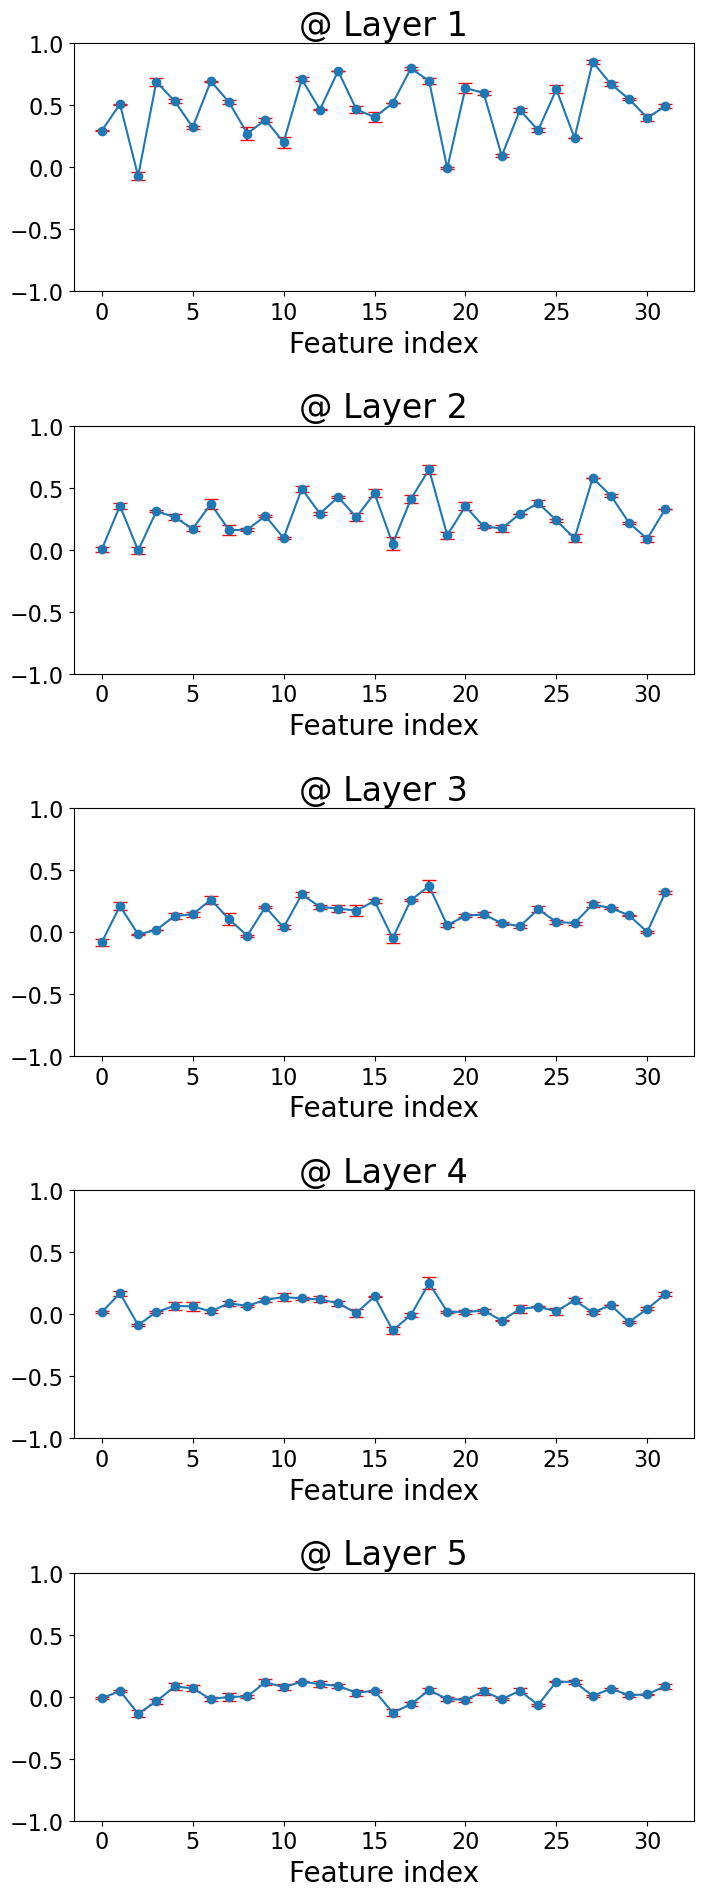

In [34]:
# Initialize model
model = GraphMatchingNetwork(cfg)

# Get node and graph features
node_feats, _ = gnn_inference(graphs, model=model, cfg=cfg)

# Set figure
fc="white"
ratio = 0.4
_, axs = set_figure(cfg.model.num_layers, 1,
                    fs=8, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fs_legend=1.5,
                    fc=fc, ratio=ratio+0.2)

# Plot features
plot_node_feature_avg(axs, node_feats,
                   fc=fc, ratio=ratio,
                   fmt='-o', ecolor='red', capsize=5,
                   ylim=[-1, 1])

# Save figure
plt.savefig(f"./dump/node_features_distribution_random_network.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

Pre-trained network

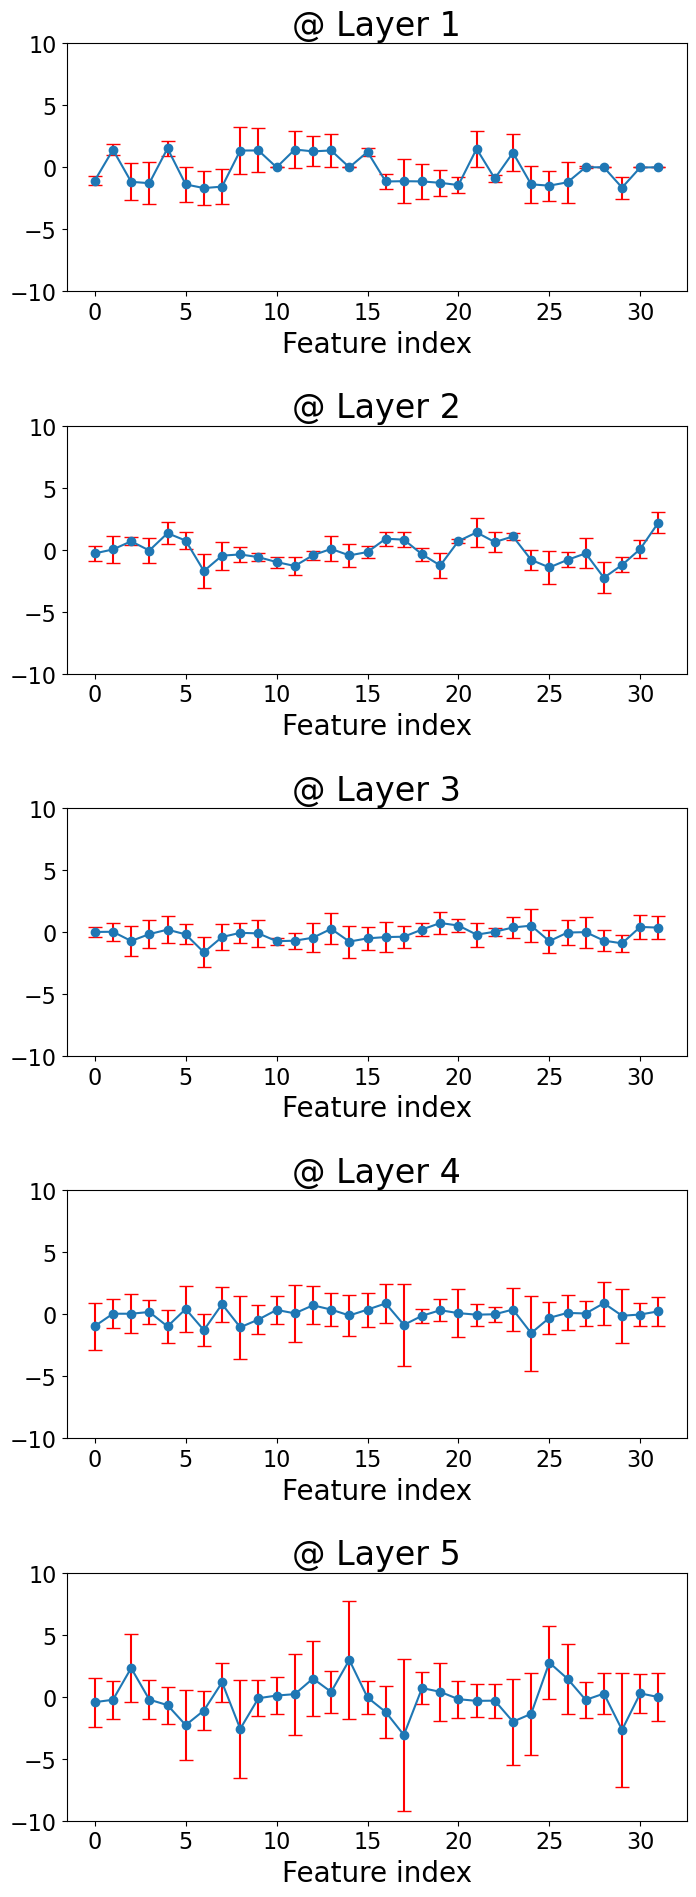

In [36]:
# Initialize model
model = GraphMatchingNetwork(cfg)
model.load_state_dict(state_dict)

# Get node and graph features
node_feats, _ = gnn_inference(graphs, model=model, cfg=cfg)

# Set figure
fc="white"
ratio = 0.4
_, axs = set_figure(cfg.model.num_layers, 1,
                    fs=8, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fs_legend=1.5,
                    fc=fc, ratio=ratio+0.2)

# Plot features
plot_node_feature_avg(axs, node_feats,
                   fc=fc, ratio=ratio,
                   fmt='-o', ecolor='red', capsize=5,
                   ylim=[-10, 10])

# Save figure
plt.savefig(f"./dump/node_features_distribution_pre-trained_network.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

## Node-to-node attention

### Computing attention

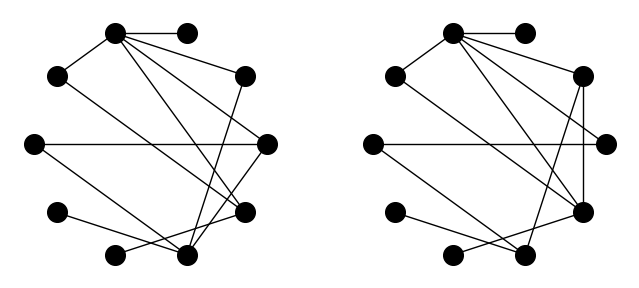

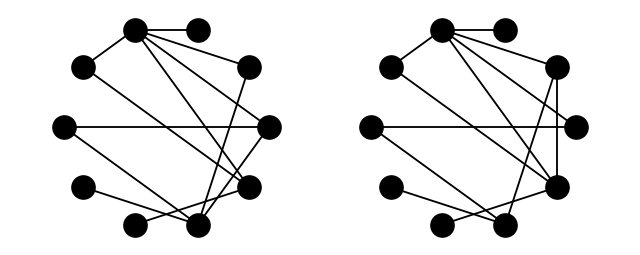

In [84]:
import networkx as nx
import numpy as np

# Random graphs and substitutions (seed for reproducibility
N, pe, k = 10, 0.2, 1
G1,_ = generate_binomial_graph(num_nodes=N, pe=pe, seed=2)
random.seed(1)
G2 = substitute_random_edges(G1, k)
G = nx.disjoint_union_all([G1, G2])

# Set up figure
fs=4
_, axs = set_figure(1, 2, fs=fs, fc="white")

# Plot the two graphs with same positions
pos_1 = nx.circular_layout(G1)
plot_graph_beautiful(G1, axs[0], c_node="black", pos=pos_1, node_size=50*fs, edge_size=fs/4)
plot_graph_beautiful(G2, axs[1], c_node="black", pos=pos_1, node_size=50*fs, edge_size=fs/4)

# Plot combined
# Set up figure
fs=8
ratio=2
_, ax = set_figure(1, 1, fs=fs, fc="white", ratio=ratio)

# Plot the two graphs with shifted positions
pos_2 = {n+N: p+np.array([3, 0]) for n, p in pos_1.items()}
pos = {**pos_1, **pos_2}
plot_graph_beautiful(G, ax, c_node="black", pos=pos, node_size=35*fs, edge_size=fs/6)

In [35]:
import torch

def cosine_similarity(X, Y):
    """
    Compute the cosine similarity (or: normalized dot-products) between two sets of vectors.

    Parameters:
    X (torch.Tensor): Matrix of shape (N_x, D) representing the first set of vectors.
    Y (torch.Tensor): Matrix of shape (N_y, D) representing the second set of vectors.

    Returns:
    torch.Tensor: Matrix C of shape (N_x, N_y) with the normalized dot-products.
    """

    # Compute dot-product matrix
    P = torch.mm(X, Y.t())

    # Compute norms of both matrices
    Xn = torch.norm(X, dim=1)
    Yn = torch.norm(Y, dim=1)

    # Compute cosine similarity matrix
    C = torch.div(P, torch.outer(Xn, Yn))

    return C

def cross_attention(x, y, sim=cosine_similarity):
    """Computes attention between x an y, and y and x"""
    a = sim(x, y)
    a_x = torch.softmax(a, dim=1)  # n->m
    a_y = torch.softmax(a, dim=0)  # m->n
    return a_x, a_y


def plot_matrix_similarity(A, fs=10, title=None):
    # Sizes
    N1 = A.shape[0]
    N2 = A.shape[1]

    # Plot settings

    fig, ax = plt.subplots(1, 1, figsize=(fs, fs))
    _ = ax.imshow(A, cmap='viridis')  # You can choose any colormap here
    # fig.colorbar(cax)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(N1), labels=np.arange(N1) + 1)
    ax.set_yticks(np.arange(N2), labels=np.arange(N2) + 1)

    # Loop over data dimensions and create text annotations.
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            ax.text(j, i, f'{A[i, j]:.2f}', va='center', ha='center', color='white',
                    fontsize=fs * 2 * 8 / np.mean([N1, N2]))

    ax.set_xlabel('Nodes G2')
    ax.set_ylabel('Nodes G1')
    ax.set_title(title)

In [85]:
# Initialize model
model = GraphMatchingNetwork(cfg)
model.load_state_dict(state_dict)

# Get node and graph features
graphs = [G1, G2]
node_feats, _ = gnn_inference(graphs, model=model, cfg=cfg)

# Get node features G1 and G2 for last layer
x = node_feats[5][:N]
y = node_feats[5][-N:]
# y = node_feats[5][:N]

# Compute cross attention
c_xy = cosine_similarity(x, y)
a_xy = cross_attention(x, y)

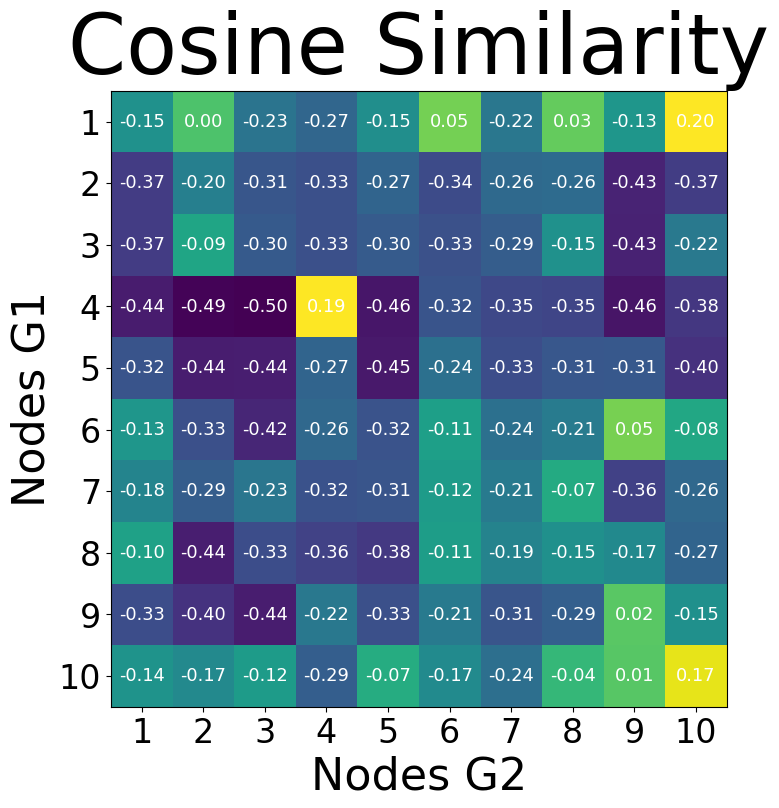

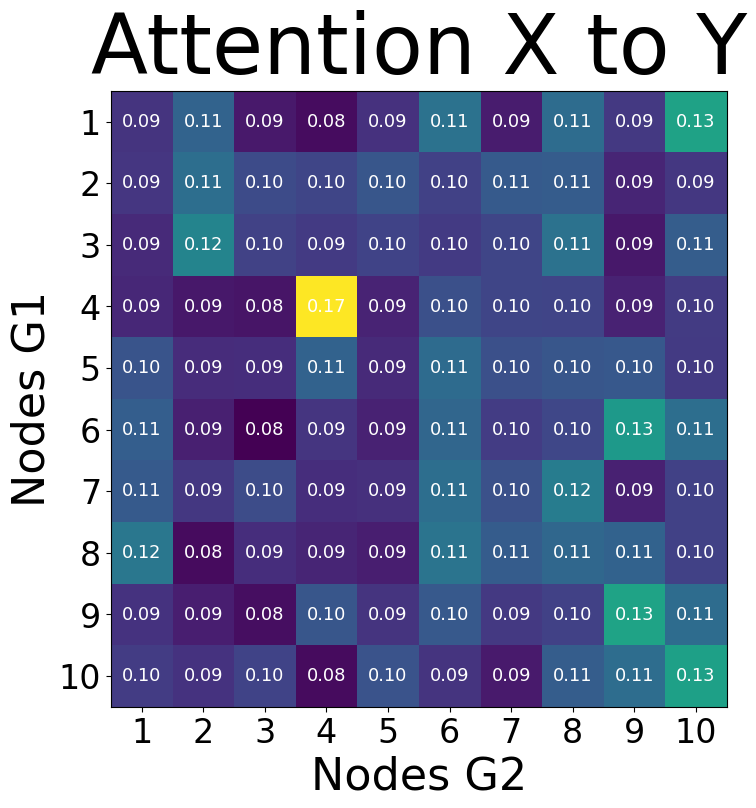

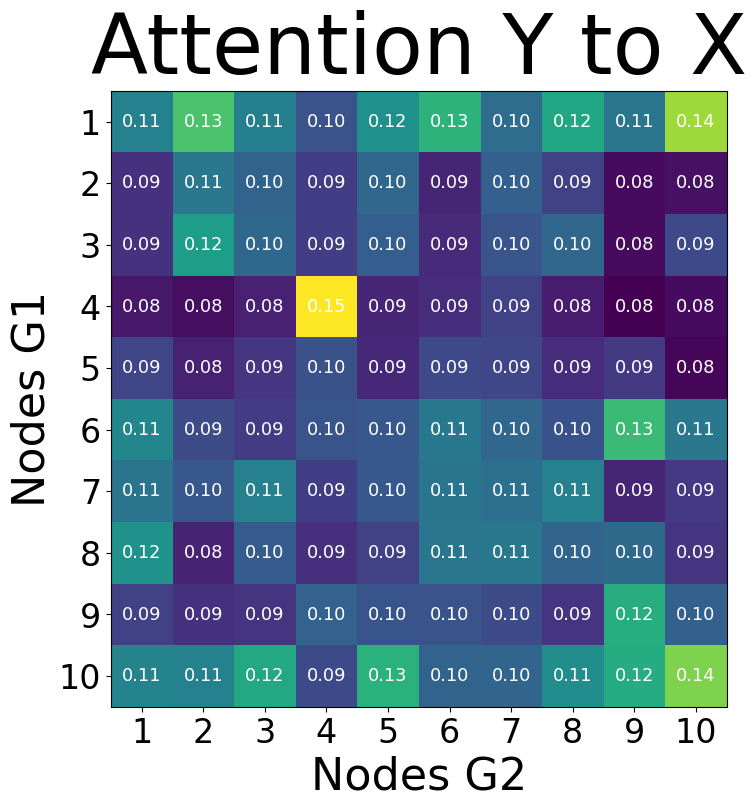

In [86]:
plot_matrix_similarity(c_xy, fs=fs, title="Cosine Similarity")
plot_matrix_similarity(a_xy[0], fs=fs, title="Attention X to Y")
plot_matrix_similarity(a_xy[1], fs=fs, title="Attention Y to X")

### Visualizing attention

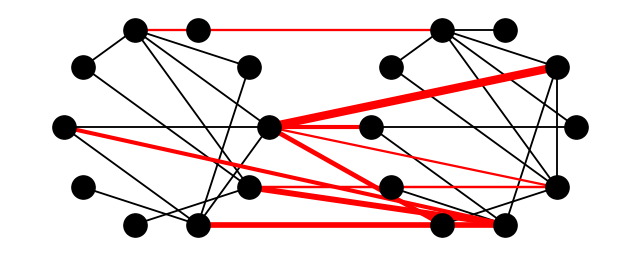

In [88]:
from itertools import combinations

# Set up figure
fs=8
ratio=2
_, ax = set_figure(1, 1, fs=fs, fc="white", ratio=ratio)

# Plot the two graphs with shifted positions
pos_2 = {n+N: p+np.array([3, 0]) for n, p in pos_1.items()}
pos = {**pos_1, **pos_2}

for n in range(c_xy.shape[0]):
    for m in range(c_xy.shape[0]):

        a_x, a_y = pos_1[n]
        b_x, b_y = pos_2[m+N]

        weight = c_xy[n, m]

        linewidth = np.log(weight) if weight > 0 else 0
        ax.plot([a_x, b_x], [a_y, b_y], linewidth=linewidth, color="red")


plot_graph_beautiful(G, ax, c_node="black", pos=pos, node_size=35*fs, edge_size=fs/6)